In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc
from sklearn.model_selection import GridSearchCV,train_test_split
from ta.momentum import RSIIndicator

# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [26]:
grt_data = pd.read_csv("C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/currency_data/GRT.csv")
sushı_data = pd.read_csv("C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/currency_data/SUSHI.csv")

In [27]:
# The columns 'vw', 'n', and 't' are unnecessary, so they are being dropped.
sushı_data.drop(columns=['vw','n','t'],inplace=True)
grt_data.drop(columns=['vw','n','t'],inplace=True)

# Renaming columns to have more understandable names for the features.
columns_mapping = {
    'c': 'close',
    'h': 'high',
    'l': 'low',
    'o': 'open',
    'v': 'volume'
}

sushı_data = sushı_data.rename(columns=columns_mapping)
grt_data = grt_data.rename(columns=columns_mapping)

In [28]:
# Adding financial features to the data.
def add_features(data) :
    data['price_range'] = data['high'] - data['low']
    data['body_size'] = data['close'] - data['open']
    data['upper_shadow'] = data['high'] - data[['open', 'close']].max(axis=1)
    data['lower_shadow'] = data[['open', 'close']].min(axis=1) - data['low']
    data['daily_return'] = (data['close'] - data['open']) / data['open']
    data['log_return'] = np.log(data['close'] / data['open'])
    data['volume_change'] = data['volume'].diff()
    data['average_price'] = (data['high'] + data['low'] + data['close']) / 3
    data['price_change'] = data['close'].diff()
    data['rolling_mean'] = data['close'].rolling(window=5).mean()
    data['rolling_std'] = data['close'].rolling(window=5).std()

    rsi_period = 14
    rsi = RSIIndicator(data['close'], window=rsi_period).rsi()
    data['rsi'] = rsi

    short_ema = data['close'].ewm(span=12, adjust=False).mean()
    long_ema = data['close'].ewm(span=26, adjust=False).mean()
    data['macd'] = short_ema - long_ema

    data['14_high'] = data['high'].rolling(window=14).max()
    data['14_low'] = data['low'].rolling(window=14).min()
    data['stochastic'] = (data['close'] - data['14_low']) / (data['14_high'] - data['14_low']) * 100

    data.drop(['14_high', '14_low'], axis=1, inplace=True)

In [29]:
add_features(sushı_data)
add_features(grt_data)

In [30]:
def specify_target(data) :
    data.loc[data["close"].shift(-1) > data["close"], "TARGET"] = 1
    data.loc[data["close"].shift(-1) <= data["close"], "TARGET"] = 0
    data.dropna(inplace=True)

In [31]:
specify_target(grt_data)
specify_target(sushı_data)

In [32]:
def normalize(data) : 
    # TARGET kolonu dışında sütunları seçme
    features = data.drop('TARGET', axis=1)
    # Standard Scaler uygulama
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    # Ölçeklenmiş verileri DataFrame'e dönüştürme
    scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
    # TARGET kolonu ile birleştirme
    data = pd.concat([scaled_features_df, data['TARGET'].reset_index(drop=True)], axis=1)

In [33]:
normalize(grt_data)
grt_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic,TARGET
13,0.565600,0.581500,0.547100,0.556800,4.819013e+05,0.034400,0.008800,0.015900,0.009700,0.015805,0.015681,-5.121584e+05,0.564733,0.007600,0.556020,0.012702,47.890651,-0.013278,55.815385,1.0
14,0.584900,0.634600,0.560300,0.566500,1.224568e+06,0.074300,0.018400,0.049700,0.006200,0.032480,0.031964,7.426670e+05,0.593267,0.019300,0.563600,0.016664,53.360127,-0.010187,68.879148,1.0
15,0.602800,0.616800,0.555000,0.585700,1.034575e+06,0.061800,0.017100,0.014000,0.030700,0.029196,0.028778,-1.899934e+05,0.591533,0.017900,0.570160,0.024451,57.785706,-0.006221,80.087664,1.0
16,0.661500,0.667200,0.590100,0.600000,1.298631e+06,0.077100,0.061500,0.005700,0.009900,0.102500,0.097580,2.640560e+05,0.639600,0.058700,0.594560,0.041284,68.381321,0.001640,97.035881,0.0
17,0.643300,0.726100,0.634500,0.661600,2.755092e+06,0.091600,-0.018300,0.064500,0.008800,-0.027660,-0.028050,1.456462e+06,0.667967,-0.018200,0.611620,0.040004,63.093585,0.006328,67.038217,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,0.208685,0.216235,0.205884,0.214861,1.114421e+05,0.010351,-0.006176,0.001374,0.002801,-0.028744,-0.029165,1.095474e+05,0.210268,-0.006065,0.209588,0.005991,38.524353,-0.016427,41.655923,0.0
1083,0.204358,0.213704,0.203900,0.208565,2.712015e+03,0.009804,-0.004207,0.005139,0.000458,-0.020171,-0.020377,-1.087301e+05,0.207321,-0.004327,0.207317,0.005187,37.032795,-0.016125,22.182437,0.0
1084,0.190407,0.208395,0.187530,0.204465,4.253311e+04,0.020865,-0.014058,0.003930,0.002877,-0.068755,-0.071233,3.982109e+04,0.195444,-0.013951,0.203817,0.009110,32.644301,-0.016817,6.248371,0.0
1085,0.160355,0.190450,0.154028,0.190450,2.231847e+05,0.036422,-0.030095,0.000000,0.006327,-0.158020,-0.172000,1.806516e+05,0.168278,-0.030052,0.195711,0.021701,25.605294,-0.019565,8.836345,1.0


In [34]:
normalize(sushı_data)
sushı_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic,TARGET
13,9.123000,9.684000,8.192000,8.593000,1.330025e+06,1.492000,0.530000,0.561000,0.401000,0.061678,0.059851,439904.890000,8.999667,0.524000,8.435800,0.464917,59.134077,0.061159,3.441678,1.0
14,10.195000,10.510000,8.992000,9.118000,9.636856e+05,1.518000,1.077000,0.315000,0.126000,0.118118,0.111647,-366339.554000,9.899000,1.072000,8.787200,0.914052,68.118383,0.192524,88.507844,0.0
15,10.162000,10.701000,9.784000,10.208000,9.146879e+05,0.917000,-0.046000,0.493000,0.378000,-0.004506,-0.004516,-48997.685000,10.215667,-0.033000,9.224400,0.951088,67.625507,0.290620,81.310680,0.0
16,9.317000,10.395000,9.049000,10.144000,9.254391e+05,1.346000,-0.827000,0.251000,0.268000,-0.081526,-0.085042,10751.192000,9.587000,-0.845000,9.479200,0.690385,56.376832,0.296756,51.827358,1.0
17,10.144000,10.254000,9.101000,9.318000,9.340558e+05,1.153000,0.826000,0.110000,0.217000,0.088646,0.084934,8616.700000,9.833000,0.827000,9.788200,0.523528,62.883917,0.364153,80.612600,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.830552,0.851520,0.820770,0.850450,0.000000e+00,0.030750,-0.019898,0.001070,0.009782,-0.023397,-0.023675,-22869.095357,0.834281,-0.019144,0.831265,0.021166,39.830265,-0.059142,66.814365,0.0
1075,0.819135,0.855079,0.817030,0.830978,3.002509e+01,0.038049,-0.011843,0.024101,0.002105,-0.014252,-0.014354,30.025089,0.830415,-0.011417,0.825193,0.018858,38.631615,-0.056598,56.615151,0.0
1076,0.782080,0.830095,0.756505,0.818474,2.245069e+04,0.073590,-0.036394,0.011621,0.025575,-0.044466,-0.045485,22420.666771,0.789560,-0.037055,0.815874,0.026622,34.954847,-0.056916,23.512596,0.0
1077,0.603322,0.783065,0.576599,0.782003,2.222200e+04,0.206466,-0.178681,0.001062,0.026723,-0.228491,-0.259408,-228.691860,0.654329,-0.178758,0.776957,0.100147,23.389697,-0.070776,9.294924,1.0


In [35]:
def split_X_y(data) :
    # "Class" feature is the target.
    X = data.drop(['TARGET'], axis=1)
    y = data['TARGET']
    print("X shape is : ", X.shape)
    print("y shape is : ", y.shape)
    return X, y

In [36]:
X_grt, y_grt = split_X_y(grt_data)
print("----------------")
X_sushı, y_sushı = split_X_y(sushı_data)

X shape is :  (1074, 19)
y shape is :  (1074,)
----------------
X shape is :  (1066, 19)
y shape is :  (1066,)


In [37]:
def data_split(X,y) : 
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Shape of X_train: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape)
    print("Shape of X_test: ", X_test.shape)
    print("Shape of y_test: ", y_test.shape)

    return X_train, X_test, y_train, y_test

In [38]:
X_train_grt, X_test_grt, y_train_grt, y_test_grt = data_split(X_grt,y_grt)
print("----------------")
X_train_sushı, X_test_sushı, y_train_sushı, y_test_sushı = data_split(X_grt,y_grt)

Shape of X_train:  (859, 19)
Shape of y_train:  (859,)
Shape of X_test:  (215, 19)
Shape of y_test:  (215,)
----------------
Shape of X_train:  (859, 19)
Shape of y_train:  (859,)
Shape of X_test:  (215, 19)
Shape of y_test:  (215,)


In [39]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective="binary:logitraw",
    booster="gbtree",
    eval_metric="aucpr",
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [40]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1,  2, 3, 6, 12],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.3, 0.5],
    "max_depth": [1, 2, 3, 4, 5, 6, 8],
    "n_estimators": [25, 50, 80, 100, 200]
}

In [41]:
# SVM parameters
cv_model_grt = GridSearchCV(XGBClassifier(random_state=42,probability=True), param_grid, refit=True, verbose=1, cv=3)  
cv_model_grt.fit(X_train_grt, y_train_grt)

# Best SVM parameters
print("Best SVM parameters: ", cv_model_grt.best_params_)
print("Best F1 score: ", cv_model_grt.best_score_)

Fitting 3 folds for each of 1890 candidates, totalling 5670 fits
Best SVM parameters:  {'gamma': 6, 'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 25}
Best F1 score:  0.5727605727605728


In [42]:
# Build Classification Model 1
xgb_classifier = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    n_estimators=25,
    learning_rate=0.3,
    max_depth=1,
    gamma=6,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [43]:
# Modeli eğitin ve eval_pcaset ile kayıp ve hata metriklerini takip edin
eval_set = [(X_train_grt, y_train_grt), (X_test_grt, y_test_grt)]

xgb_classifier.fit(X_train_grt, y_train_grt, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=6, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=25,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [44]:
def present_classificaion_result(test,pred) :

    print("-------Classification Report-------")
    print(classification_report(test, pred))

    conf_matrix = confusion_matrix(test, pred)
    print("-------Confusion Matrix-------")
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0,1], yticklabels=[0,1])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

-------Classification Report-------
              precision    recall  f1-score   support

         0.0       0.49      0.75      0.59       101
         1.0       0.58      0.30      0.39       114

    accuracy                           0.51       215
   macro avg       0.53      0.53      0.49       215
weighted avg       0.53      0.51      0.49       215

-------Confusion Matrix-------


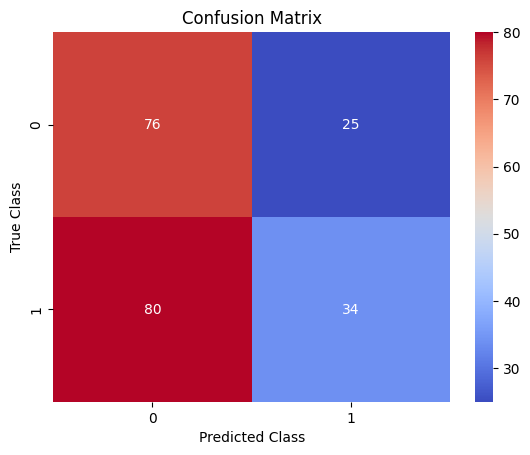

In [45]:
y_pred = xgb_classifier.predict(X_test_grt)
present_classificaion_result(y_test_grt,y_pred)

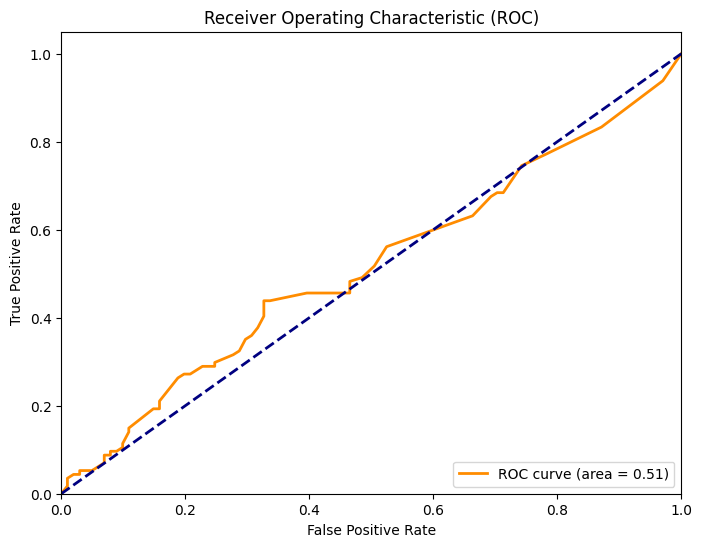

In [46]:
# Test seti üzerinde tahmin yapın
y_prob = xgb_classifier.predict_proba(X_test_grt)[:, 1]

# ROC eğrisi için gerçek değerler ve tahmin edilen olasılıkları kullanın
fpr, tpr, _ = roc_curve(y_test_grt, y_prob)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiz
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [47]:
# Modeli kaydetme
xgb_classifier.save_model('xgb_classifier_model.json')